## Installing and Importing Packages

In [1]:
import sys
print("Python version:", sys.version)

import numpy as np
import pandas as pd
import sklearn
import codecarbon
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Sklearn:", sklearn.__version__)
print("CodeCarbon:", codecarbon.__version__)


Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]
Numpy: 2.2.6
Pandas: 2.3.3
Sklearn: 1.7.2
CodeCarbon: 3.1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error

from codecarbon import EmissionsTracker


## Loading the Dataset

In [3]:
import os

print("Files in project directory:")
os.listdir()


Files in project directory:


['.git',
 '.ipynb_checkpoints',
 'AirQualityUCI.csv',
 'aq_supervised_baseline.csv',
 'aq_unsupervised_baseline.csv',
 'data',
 'electricity_meters.csv',
 'elec_supervised_baseline.csv',
 'elec_unsupervised_baseline.csv',
 'emissions.csv',
 'Final_Greenai.py',
 'Final_Notebook.ipynb',
 'GreenAI.ipynb',
 'models',
 'results',
 'run_air_quality_baseline.py',
 'run_electricity_baseline.py',
 'run_tuning.py',
 'src',
 'streamlit_app.py',
 'Untitled.ipynb',
 'x23426918_Codefile.ipynb',
 'x23426918_Codefile.py']

## Utility Functions - Carbon Tracker

In [4]:
import time
from contextlib import contextmanager
from codecarbon import EmissionsTracker

@contextmanager
def carbon_tracker(run_name: str, output_dir: str = "results"):
    """
    Track carbon emissions for any code block.
    Example:
        with carbon_tracker("train_model"):
            model.fit(X, y)
    """
    tracker = EmissionsTracker(project_name=run_name, output_dir=output_dir, save_to_file=True)
    tracker.start()
    try:
        yield
    finally:
        emissions = tracker.stop()
        print(f"[CodeCarbon] {run_name} CO2(kg): {emissions}")


def run_with_carbon(run_name: str, func, *args, **kwargs):
    """
    Run a function while measuring CO2 emissions and time.
    Returns (result, co2_kg, seconds)
    """
    tracker = EmissionsTracker(project_name=run_name, output_dir="results", save_to_file=True)
    tracker.start()
    t0 = time.time()
    try:
        result = func(*args, **kwargs)
    finally:
        co2 = tracker.stop()
    secs = time.time() - t0
    print(f"[CodeCarbon] {run_name} CO2(kg): {co2}, time(s): {secs:.3f}")
    return result, (co2 if co2 is not None else 0.0), secs


## Exploratory Data Analysis 

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

def load_raw_any(path):
    """
    Load AirQualityUCI.csv safely as:
    - Excel (.xlsx disguised as .csv)
    - CSV with unknown encoding
    - CSV with wrong separators
    """
    path = Path(path)

    try:
        df = pd.read_excel(path, engine="openpyxl")
        print("Loaded as EXCEL file")
        return df
    except:
        pass

    try:
        df = pd.read_csv(path, sep=None, engine="python", encoding="latin1")
        print("Loaded as CSV (auto-separator, latin1)")
        return df
    except:
        pass

    attempts = [
        ("utf-8", ";"),
        ("utf-8", ","),
        ("latin1", ";"),
        ("latin1", ","),
        ("utf-8-sig", ";"),
        ("utf-16", None),
        ("utf-16", ";"),
    ]

    for enc, sep in attempts:
        try:
            if sep is None:
                df = pd.read_csv(path, encoding=enc, sep=None, engine="python")
            else:
                df = pd.read_csv(path, encoding=enc, sep=sep)
            print(f"Loaded as CSV (encoding={enc}, sep='{sep}')")
            return df
        except:
            continue

    raise ValueError("Could not load file as CSV or Excel.")


In [6]:
aq_raw = load_raw_any("data/AirQualityUCI.csv")
aq_raw.head()


Loaded as EXCEL file


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


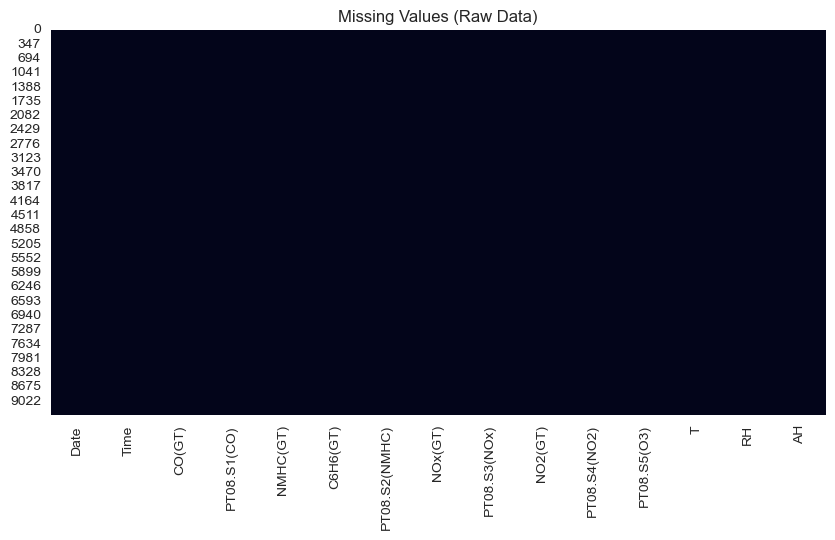

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [7]:
plt.figure(figsize=(10, 5))
sns.heatmap(aq_raw.isna(), cbar=False)
plt.title("Missing Values (Raw Data)")
plt.show()

aq_raw.isna().sum().sort_values(ascending=False)


In [8]:
aq_raw.describe(include="all").T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Date,9357,NaN,NaN,NaN,2004-09-21 04:30:05.193972480,2004-03-10 00:00:00,2004-06-16 00:00:00,2004-09-21 00:00:00,2004-12-28 00:00:00,2005-04-04 00:00:00,NaN
Time,9357,24,18:00:00,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO(GT),9357.0,NaN,NaN,NaN,-34.207524,-200.0,0.6,1.5,2.6,11.9,77.65717
PT08.S1(CO),9357.0,NaN,NaN,NaN,1048.869652,-200.0,921.0,1052.5,1221.25,2039.75,329.817015
NMHC(GT),9357.0,NaN,NaN,NaN,-159.090093,-200.0,-200.0,-200.0,-200.0,1189.0,139.789093
C6H6(GT),9357.0,NaN,NaN,NaN,1.865576,-200.0,4.004958,7.886653,13.636091,63.741476,41.380154
PT08.S2(NMHC),9357.0,NaN,NaN,NaN,894.475963,-200.0,711.0,894.5,1104.75,2214.0,342.315902
NOx(GT),9357.0,NaN,NaN,NaN,168.6042,-200.0,50.0,141.0,284.2,1479.0,257.424561
PT08.S3(NOx),9357.0,NaN,NaN,NaN,794.872333,-200.0,637.0,794.25,960.25,2682.75,321.977031
NO2(GT),9357.0,NaN,NaN,NaN,58.135898,-200.0,53.0,96.0,133.0,339.7,126.931428


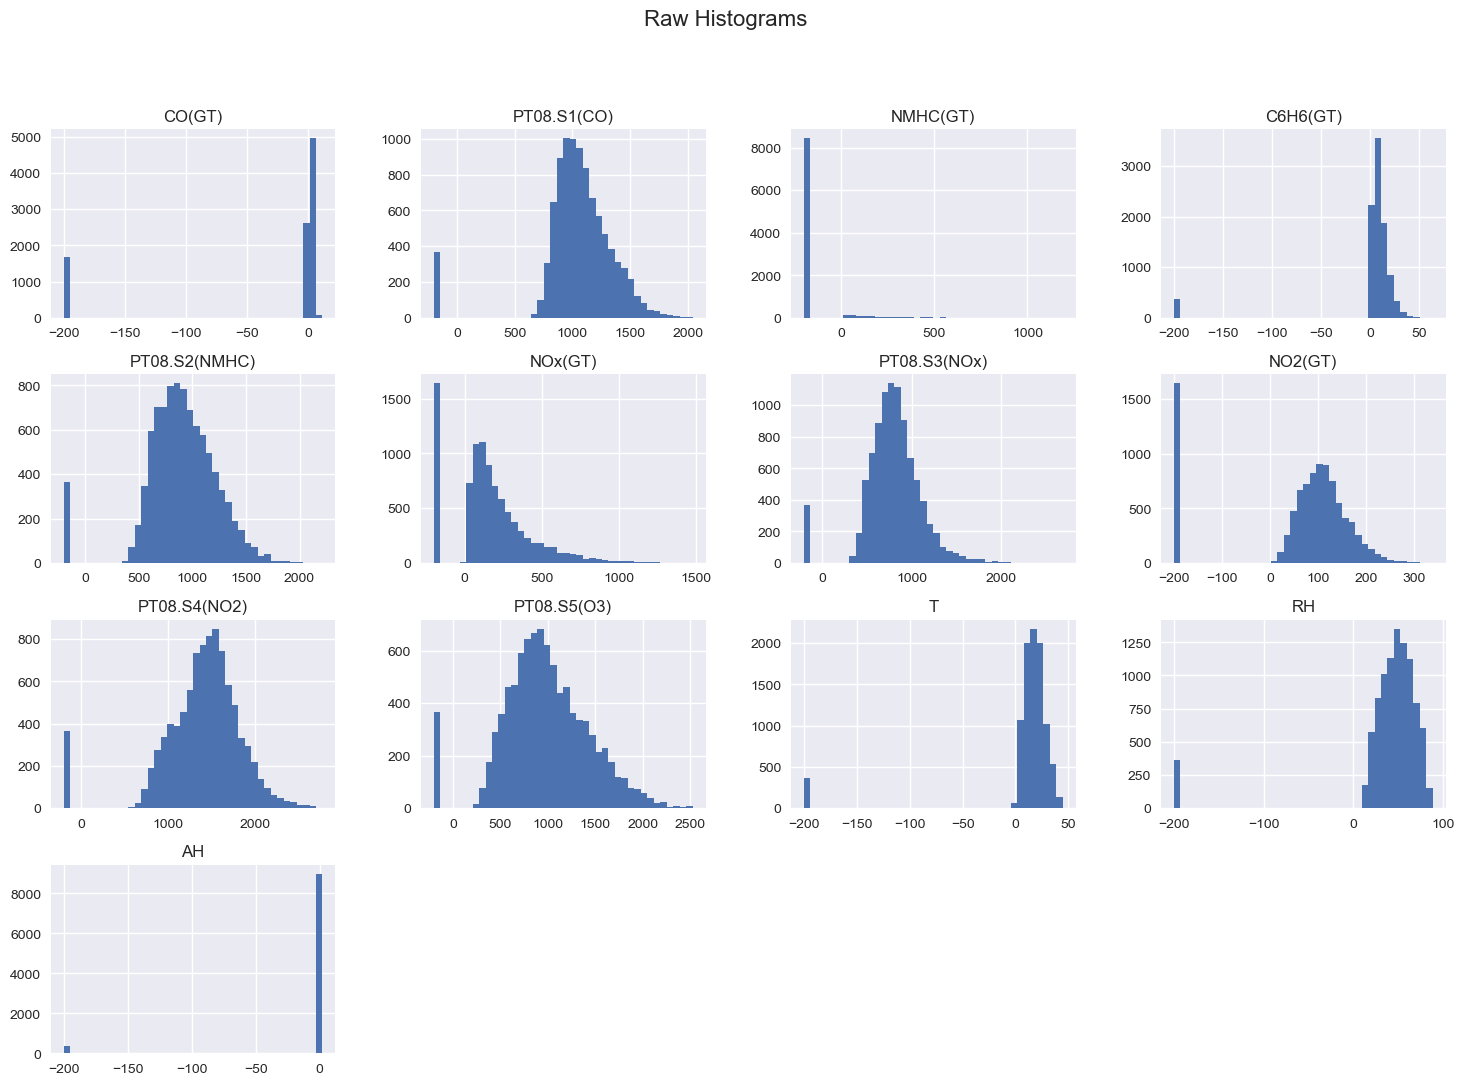

In [9]:
aq_raw.select_dtypes(include=[np.number]).hist(figsize=(18, 12), bins=40)
plt.suptitle("Raw Histograms", fontsize=16)
plt.show()


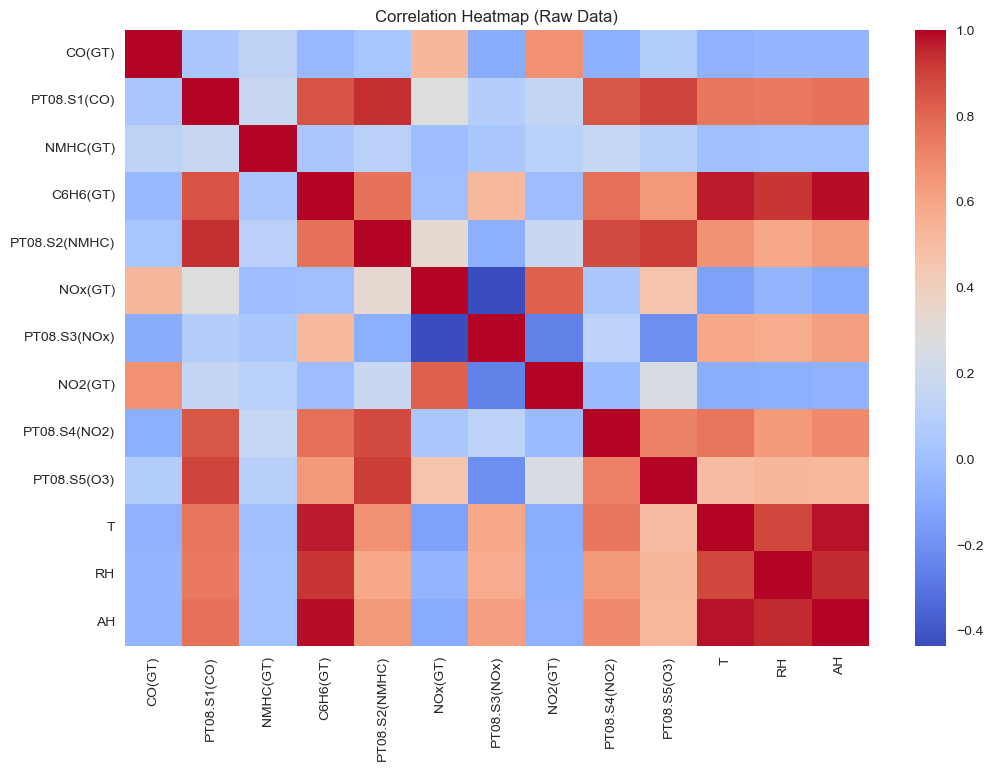

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(aq_raw.select_dtypes(include=[np.number]).corr(),
            cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Raw Data)")
plt.show()


##  Data Cleaning & Preprocessing

In [11]:
# Air Quality Data Preprocessing

import pandas as pd
import numpy as np
from pathlib import Path

def _is_excel_file(path: Path) -> bool:
    try:
        if path.suffix.lower() in {".xlsx", ".xls"}:
            return True
        with open(path, "rb") as f:
            sig = f.read(4)
        return sig[:2] == b"PK"
    except Exception:
        return False

def _try_read_csv_variants(path: Path) -> pd.DataFrame:
    errors = []
    candidates = [
        ("utf-8", None), ("latin1", None), ("latin1", ";"),
        ("latin1", ","), ("utf-16", None), ("utf-16", ";"),
        ("utf-16", ","), ("utf-8-sig", None),
    ]

    for enc, sep in candidates:
        try:
            kwargs = dict(encoding=enc, on_bad_lines="skip")
            if sep is None:
                df = pd.read_csv(path, sep=None, engine="python", **kwargs)
            else:
                df = pd.read_csv(path, sep=sep, **kwargs)
            if df.shape[1] <= 1:
                errors.append(ValueError(f"Only {df.shape[1]} col with enc={enc}, sep={sep}"))
                continue
            return df
        except Exception as e:
            errors.append(e)
            continue

    raise errors[-1]

def _coerce_decimal_commas(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in out.columns:
        if out[col].dtype == object:
            sample = out[col].dropna().astype(str).head(100)
            if (sample.str.contains(r'\d,\d').mean() > 0.3):
                out[col] = (out[col].astype(str)
                    .str.replace('.', '', regex=False)
                    .str.replace(',', '.', regex=False)
                )
        out[col] = pd.to_numeric(out[col], errors='ignore')

    for col in out.columns:
        if out[col].dtype == object:
            out[col] = pd.to_numeric(out[col], errors='ignore')

    return out

def load_air_quality(csv_path: str) -> pd.DataFrame:
    path = Path(csv_path)

    if _is_excel_file(path):
        df = pd.read_excel(path, engine="openpyxl")
    else:
        df = _try_read_csv_variants(path)

    df = df[[c for c in df.columns if not str(c).lower().startswith('unnamed')]]
    df.columns = [str(c).strip() for c in df.columns]

    has_date = any(c.lower() == 'date' for c in df.columns)
    has_time = any(c.lower() == 'time' for c in df.columns)

    if has_date and has_time and "datetime" not in df.columns:
        df['datetime'] = pd.to_datetime(
            df['Date'].astype(str).str.strip() + ' ' + df['Time'].astype(str).str.strip(),
            errors='coerce',
            dayfirst=True
        )
        df = df.drop(columns=['Date', 'Time'], errors='ignore')

    df = _coerce_decimal_commas(df)
    df = df.replace(-200, np.nan)

    if "datetime" in df.columns:
        df = df.sort_values("datetime")

    for c in df.columns:
        if c != "datetime":
            df[c] = pd.to_numeric(df[c], errors='coerce')

    df = df.dropna(how='all')
    return df

def make_supervised_target(df: pd.DataFrame, pollutant: str = "CO(GT)", threshold: float = 2.0):
    if pollutant not in df.columns:
        raise ValueError(f"{pollutant} not in DataFrame columns.")
    return (df[pollutant] > threshold).astype(int)


In [12]:
# Electricity Data Preprocessing

import pandas as pd
import re

def load_electricity_consumption(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        csv_path,
        sep=";",
        quotechar='"',
        engine="python",
        decimal=",",
    )

    first_col = df.columns[0]
    if (first_col is None) or (str(first_col).strip() == "") or ("unnamed" in str(first_col).lower()):
        df = df.rename(columns={df.columns[0]: "timestamp"})
    else:
        df = df.rename(columns={first_col: "timestamp"})

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    meter_cols = [
        c for c in df.columns
        if re.match(r'^"?MT_\d{3}"?$', str(c)) or re.match(r"^MT_\d{3}$", str(c))
    ]
    meter_cols_clean = [str(c).strip('"') for c in meter_cols]
    df = df.rename(columns={old: new for old, new in zip(meter_cols, meter_cols_clean)})
    meter_cols = meter_cols_clean

    for c in meter_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df[["timestamp"] + meter_cols].dropna(how="all", axis=1)
    meter_cols = [c for c in meter_cols if c in df.columns]

    df = df.set_index("timestamp").sort_index()
    return df

def build_monthly_series(df: pd.DataFrame, how: str = "sum") -> pd.DataFrame:
    total = df.sum(axis=1, skipna=True) if how == "sum" else df.mean(axis=1, skipna=True)
    monthly = total.resample("M").sum(min_count=1) if how == "sum" else total.resample("M").mean()

    out = monthly.to_frame(name="Value").reset_index()
    out = out.rename(columns={"timestamp": "Month"})
    out["Month"] = pd.to_datetime(out["Month"])
    return out.dropna().sort_values("Month").reset_index(drop=True)

def build_time_features(monthly_df: pd.DataFrame) -> pd.DataFrame:
    df = monthly_df.copy()
    df["year"] = df["Month"].dt.year
    df["month"] = df["Month"].dt.month

    for lag in [1, 2, 3, 6, 12]:
        df[f"lag_{lag}"] = df["Value"].shift(lag)

    df["target_next"] = df["Value"].shift(-1)
    return df.dropna().reset_index(drop=True)


## EDA After Data Cleaning

In [13]:
from src.data_prep_air_quality import load_air_quality

aq_clean = load_air_quality("data/AirQualityUCI.csv")
aq_clean.head()


D:\greenai-thesis\src\data_prep_air_quality.py:74: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  out[col] = pd.to_numeric(out[col], errors='ignore')


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
1169,2.8,1364.00,386.0,16.835634,1205.00,196.0,722.75,139.0,1850.25,1565.75,26.700,28.675000,0.989504,-9223372036854775808
6336,2.3,1160.75,NaN,10.043405,979.25,267.0,757.50,115.0,1375.25,1132.25,16.725,57.250000,1.081335,-9223372036854775808
6337,1.8,1117.25,NaN,7.322456,870.75,182.0,781.25,94.0,1320.25,985.50,17.275,56.974999,1.113702,-9223372036854775808
6338,1.9,1114.25,NaN,7.345851,871.75,197.0,857.00,98.0,1309.50,991.25,16.750,58.725000,1.110929,-9223372036854775808
6339,1.4,1021.50,NaN,4.620274,744.00,149.0,1224.00,87.0,1209.50,846.50,16.500,59.175000,1.102075,-9223372036854775808


In [14]:
print("Clean Shape:", aq_clean.shape)
aq_clean.info()


Clean Shape: (9357, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 1169 to 8813
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       914 non-null    float64
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        7718 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        7715 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
 13  datetime       9357 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


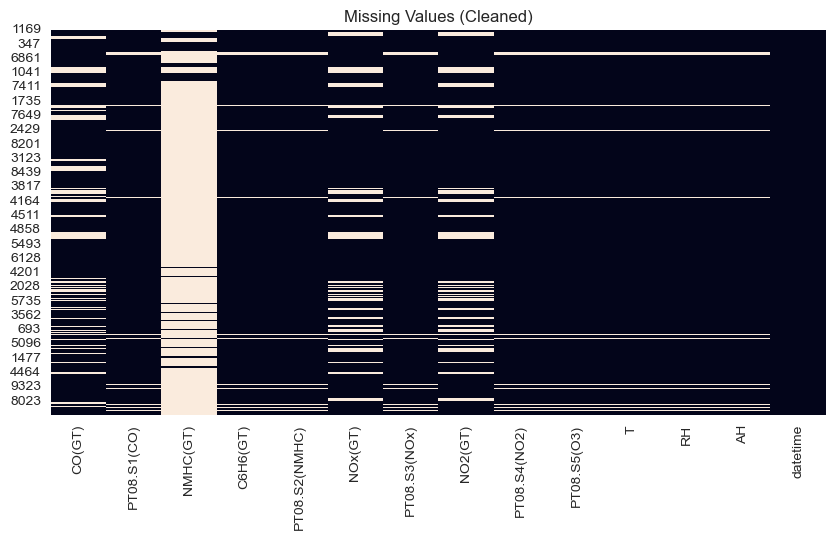

NMHC(GT)         8443
CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
C6H6(GT)          366
PT08.S1(CO)       366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
datetime            0
dtype: int64

In [15]:
plt.figure(figsize=(10, 5))
sns.heatmap(aq_clean.isna(), cbar=False)
plt.title("Missing Values (Cleaned)")
plt.show()

aq_clean.isna().sum().sort_values(ascending=False)


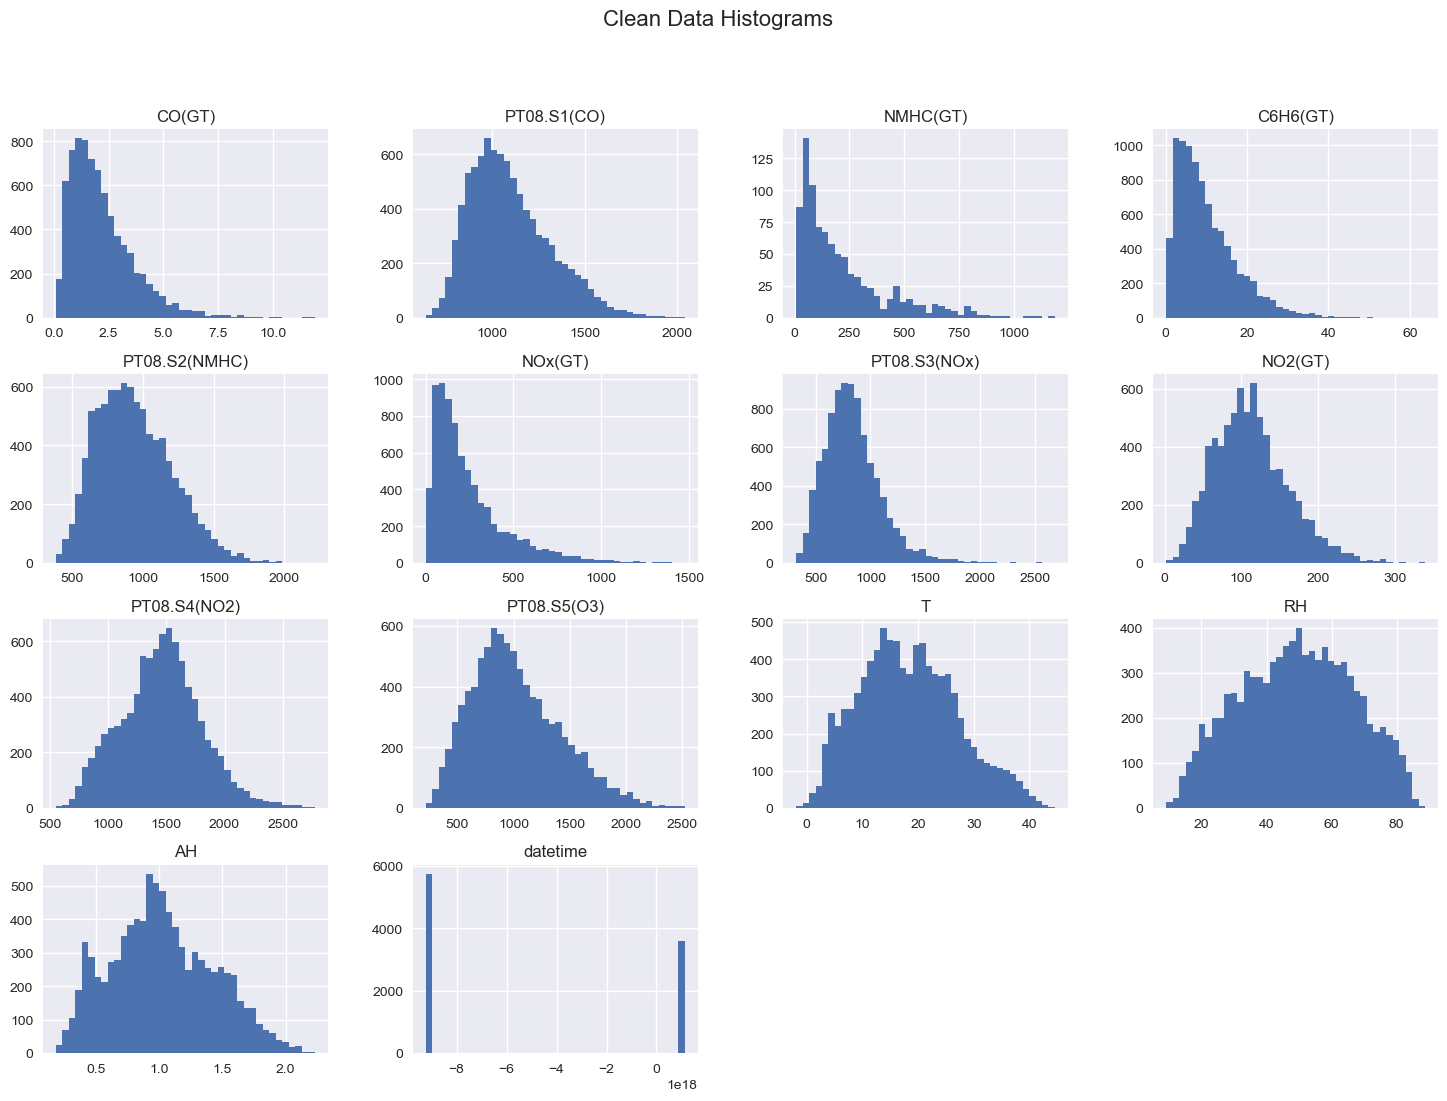

In [16]:
aq_clean.select_dtypes(include=[np.number]).hist(figsize=(18, 12), bins=40)
plt.suptitle("Clean Data Histograms", fontsize=16)
plt.show()


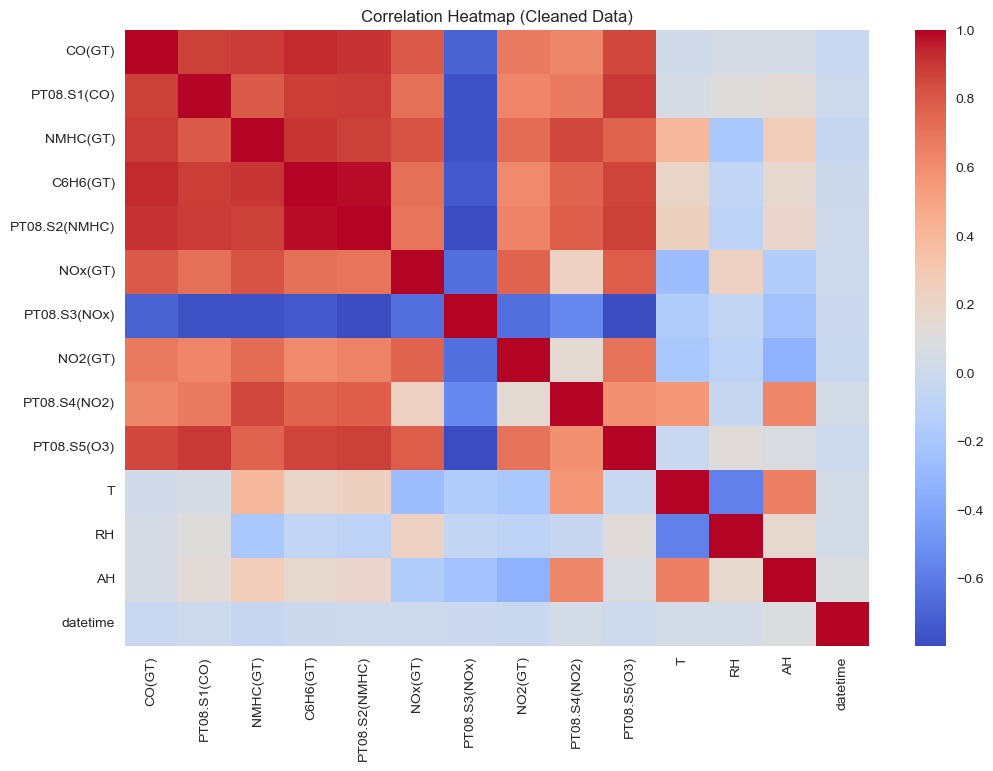

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(aq_clean.select_dtypes(include=[np.number]).corr(),
            cmap="coolwarm")
plt.title("Correlation Heatmap (Cleaned Data)")
plt.show()


## Feature Engineering

In [18]:
# Loading Air Quality

import pandas as pd

df_air = pd.read_excel("data/AirQualityUCI.csv", engine="openpyxl")

# Remove unnamed junk columns 

df_air = df_air.loc[:, ~df_air.columns.str.contains("Unnamed")]

print("Air dataset loaded:", df_air.shape)
df_air.head()




Air dataset loaded: (9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [19]:
# Air Quality - Feature engineering

import pandas as pd
import numpy as np

feat_air = df_air.copy()

# Timestamp Handling

date_col = None
time_col = None

for col in feat_air.columns:
    if col.lower() == "date":
        date_col = col
    if col.lower() == "time":
        time_col = col

if date_col and time_col:

    # Convert both to strings safely
    date_str = feat_air[date_col].astype(str)
    time_str = feat_air[time_col].astype(str)

    feat_air["timestamp"] = pd.to_datetime(
        date_str + " " + time_str, errors="coerce"
    )

    feat_air = feat_air.drop(columns=[date_col, time_col])
    
elif date_col and not time_col:
    feat_air["timestamp"] = pd.to_datetime(
        feat_air[date_col], errors="coerce"
    )
    feat_air = feat_air.drop(columns=[date_col])

else:
    feat_air["timestamp"] = pd.to_datetime(
        feat_air.index, errors="coerce"
    )

# Clean timestamp
feat_air = feat_air.dropna(subset=["timestamp"])
feat_air = feat_air.set_index("timestamp").sort_index()

# Target Selection

candidate_targets = [
    "CO(GT)", "C6H6(GT)", "NO2(GT)", "T", "RH", "AH"
]

target_col_air = None
for col in candidate_targets:
    if col in feat_air.columns:
        target_col_air = col
        break

if target_col_air is None:
    target_col_air = feat_air.select_dtypes(include=[np.number]).columns[0]

print("Selected Air Quality Target:", target_col_air)

# Feature Engineering

feat_air["hour"] = feat_air.index.hour
feat_air["day"] = feat_air.index.day
feat_air["month"] = feat_air.index.month

feat_air["lag_1"] = feat_air[target_col_air].shift(1)
feat_air["lag_2"] = feat_air[target_col_air].shift(2)

feat_air["roll_3"] = feat_air[target_col_air].rolling(3).mean()
feat_air["roll_6"] = feat_air[target_col_air].rolling(6).mean()
feat_air["roll_12"] = feat_air[target_col_air].rolling(12).mean()

feat_air = feat_air.dropna()

# ML preparation

y_air_fe = feat_air[target_col_air]
X_air_fe = feat_air.drop(columns=[target_col_air])

X_air_fe = X_air_fe.apply(pd.to_numeric, errors="coerce")
y_air_fe = pd.to_numeric(y_air_fe, errors="coerce")

mask = X_air_fe.notna().all(axis=1) & y_air_fe.notna()
X_air_fe = X_air_fe[mask]
y_air_fe = y_air_fe[mask]

print("Air FE shapes:", X_air_fe.shape, y_air_fe.shape)


Selected Air Quality Target: CO(GT)
Air FE shapes: (9346, 20) (9346,)


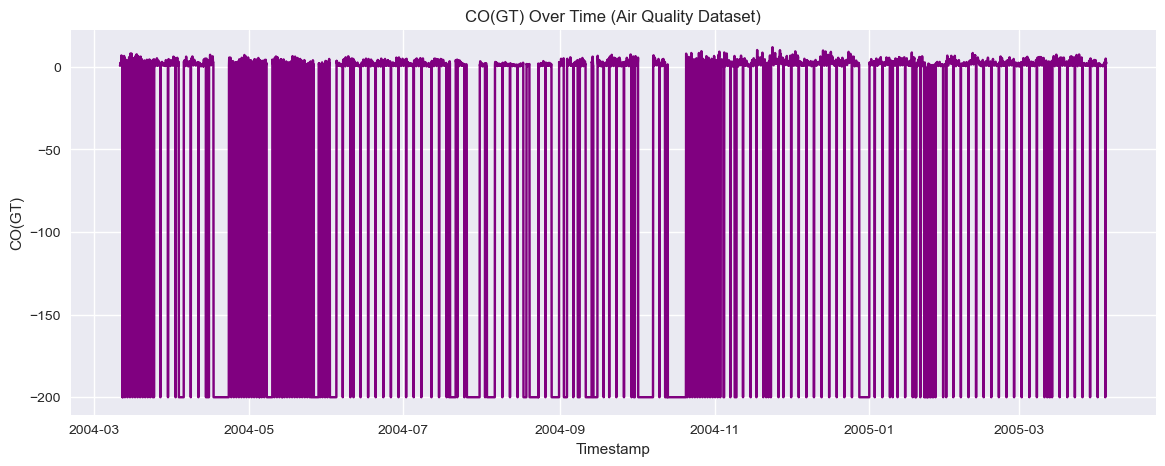

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(feat_air.index, y_air_fe, color="purple")
plt.title(f"{target_col_air} Over Time (Air Quality Dataset)")
plt.xlabel("Timestamp")
plt.ylabel(target_col_air)
plt.grid(True)
plt.show()


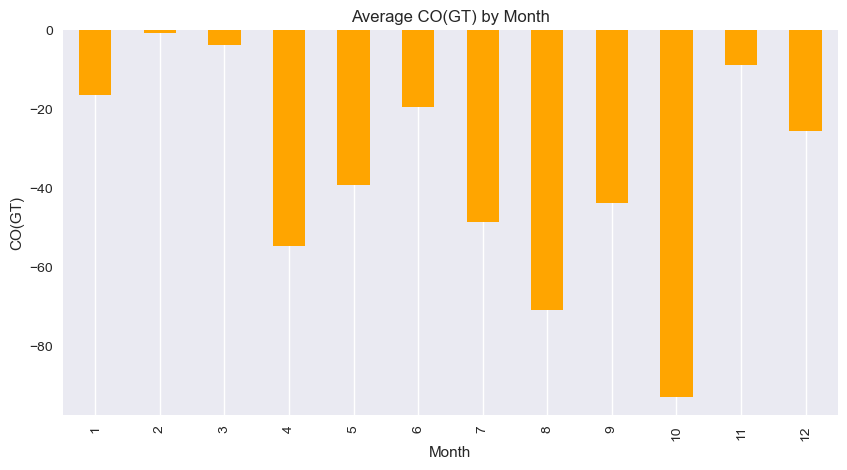

In [21]:
plt.figure(figsize=(10,5))
feat_air.groupby("month")[target_col_air].mean().plot(
    kind="bar", color="orange"
)
plt.title(f"Average {target_col_air} by Month")
plt.xlabel("Month")
plt.ylabel(target_col_air)
plt.grid(axis="y")
plt.show()


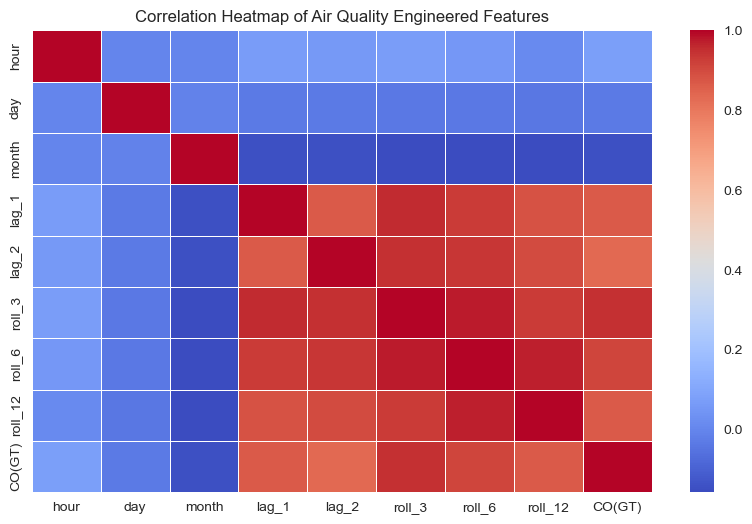

In [22]:
import seaborn as sns
import numpy as np

corr_cols = ["hour", "day", "month", "lag_1", "lag_2", "roll_3", "roll_6", "roll_12", target_col_air]

plt.figure(figsize=(10,6))
sns.heatmap(
    feat_air[corr_cols].corr(),
    annot=False,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Air Quality Engineered Features")
plt.show()


In [23]:
# Electricity Data - Loading

import pandas as pd
import numpy as np

# Load electricity dataset
df_el = pd.read_csv("data/electricity_meters.csv", sep=";", engine="python")

# Rename timestamp column
first_col = df_el.columns[0]
df_el = df_el.rename(columns={first_col: "timestamp"})

# Convert timestamp
df_el["timestamp"] = pd.to_datetime(df_el["timestamp"], errors="coerce")
df_el = df_el.dropna(subset=["timestamp"])
df_el = df_el.set_index("timestamp").sort_index()

print("Electricity data loaded:", df_el.shape)


Electricity data loaded: (140256, 370)


In [24]:
# Auto Detect columns

# Detect all meter-like columns
raw_meter_cols = [c for c in df_el.columns if c.startswith("MT_")]

# Keeping only columns that exist 
meter_cols = [c for c in raw_meter_cols if c in df_el.columns]

print(f"Detected {len(meter_cols)} valid meter columns.")


Detected 370 valid meter columns.


In [25]:
# Cleaning and converting data

# Convert meter data to numeric
df_el[meter_cols] = df_el[meter_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows where data mising
df_el = df_el.dropna(how="all", subset=meter_cols)

print("After cleaning:", df_el.shape)

# Clean and convert meter data

# Convert meter data to numeric
df_el[meter_cols] = df_el[meter_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows where all meters are missing
df_el = df_el.dropna(how="all", subset=meter_cols)

print("After cleaning:", df_el.shape)


After cleaning: (140256, 370)
After cleaning: (140256, 370)


In [26]:
# Feature Engineering

feat_fe = df_el.copy()

# Aggregate features across all meters
feat_fe["total_consumption"] = feat_fe[meter_cols].sum(axis=1)
feat_fe["avg_consumption"]   = feat_fe[meter_cols].mean(axis=1)
feat_fe["max_consumption"]   = feat_fe[meter_cols].max(axis=1)
feat_fe["min_consumption"]   = feat_fe[meter_cols].min(axis=1)

# Time features
feat_fe["hour"]  = feat_fe.index.hour
feat_fe["day"]   = feat_fe.index.day
feat_fe["month"] = feat_fe.index.month

print("Feature engineering completed:", feat_fe.shape)


Feature engineering completed: (140256, 377)


In [27]:
# =Define Target

target_col_el = "total_consumption"

y_el_fe = feat_fe[target_col_el]
X_el_fe = feat_fe.drop(columns=[target_col_el])

# Convert to numeric
X_el_fe = X_el_fe.apply(pd.to_numeric, errors="coerce")
y_el_fe = pd.to_numeric(y_el_fe, errors="coerce")

# Drop rows with missing values
mask_el = X_el_fe.notna().all(axis=1) & y_el_fe.notna()
X_el_fe = X_el_fe[mask_el]
y_el_fe = y_el_fe[mask_el]

print("Final feature shapes:", X_el_fe.shape, y_el_fe.shape)


Final feature shapes: (0, 376) (0,)


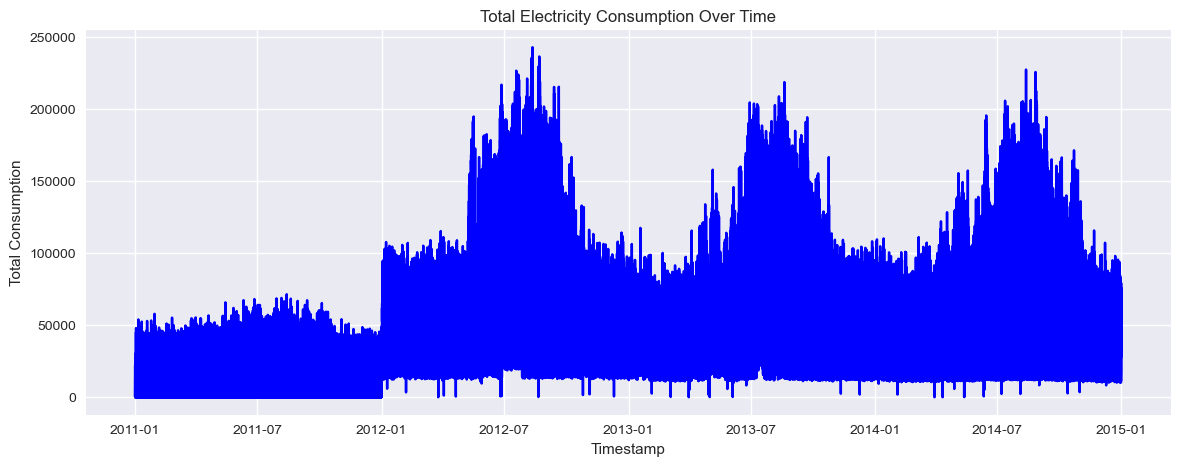

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(feat_fe.index, feat_fe["total_consumption"], color='blue')
plt.title("Total Electricity Consumption Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Total Consumption")
plt.grid(True)
plt.show()


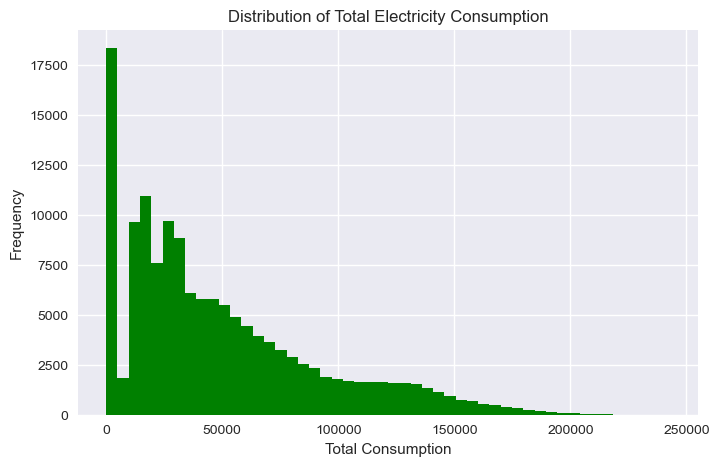

In [29]:
plt.figure(figsize=(8,5))
plt.hist(feat_fe["total_consumption"], bins=50, color='green')
plt.title("Distribution of Total Electricity Consumption")
plt.xlabel("Total Consumption")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


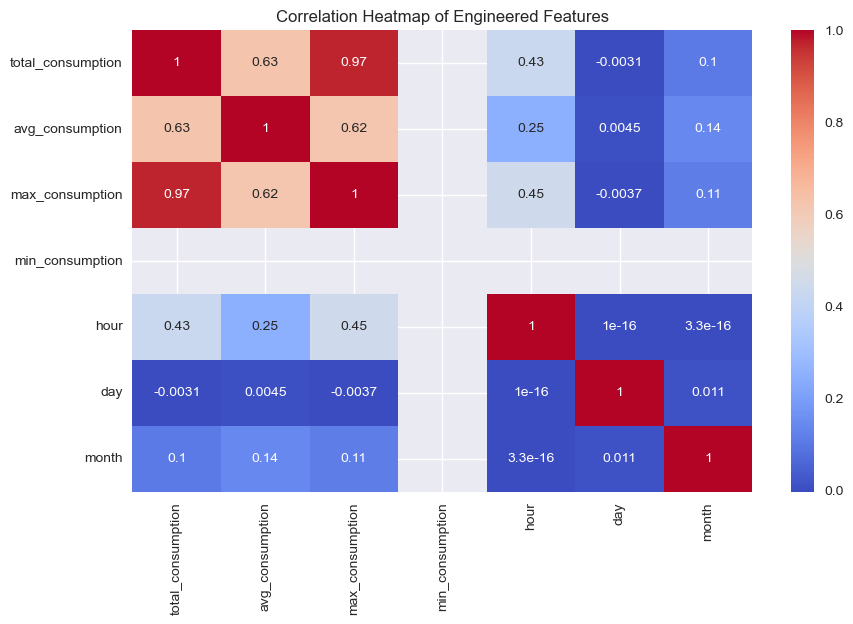

In [30]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(feat_fe[["total_consumption", "avg_consumption", "max_consumption", "min_consumption", 
                     "hour", "day", "month"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Engineered Features")
plt.show()


## Baseline Models 

In [31]:
# Basic Imports
import pandas as pd
import numpy as np
import re
from pathlib import Path

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regressor(name, model, X_train, X_test, y_train, y_test):
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    preds = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae  = mean_absolute_error(y_test, preds)
    r2   = r2_score(y_test, preds)

    # Pretty print
    print(f"\nModel: {name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R^2 : {r2:.4f}")

    return {
        "model": name,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }


# For electricity regression
from sklearn.ensemble import RandomForestRegressor

# Carbon Tracking
try:
    from codecarbon import EmissionsTracker
except:
    EmissionsTracker = None


In [32]:
import pandas as pd
import numpy as np
from pathlib import Path

# Detection helpers 
def _is_excel_file(path: Path) -> bool:
    try:
        if path.suffix.lower() in {".xlsx", ".xls"}:
            return True
        with open(path, "rb") as f:
            sig = f.read(4)
        return sig[:2] == b"PK"
    except Exception:
        return False

def _try_read_csv_variants(path: Path) -> pd.DataFrame:
    candidates = [
        ("utf-8", None),
        ("latin1", None),
        ("latin1", ";"),
        ("latin1", ","),
        ("utf-16", None),
        ("utf-16", ";"),
        ("utf-16", ","),
        ("utf-8-sig", None),
    ]
    errors = []
    for enc, sep in candidates:
        try:
            kwargs = dict(encoding=enc, on_bad_lines="skip")
            if sep is None:
                df = pd.read_csv(path, sep=None, engine="python", **kwargs)
            else:
                df = pd.read_csv(path, sep=sep, **kwargs)
            if df.shape[1] <= 1:
                continue
            return df
        except Exception as e:
            errors.append(e)
    raise errors[-1]

def _coerce_decimal_commas(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in out.columns:
        if out[col].dtype == object:
            sample = out[col].dropna().astype(str).head(100)
            if (sample.str.contains(r"\d,\d").mean() > 0.3):
                out[col] = (
                    out[col].astype(str)
                    .str.replace('.', '', regex=False)
                    .str.replace(',', '.', regex=False)
                )
        out[col] = pd.to_numeric(out[col], errors="ignore")
    for col in out.columns:
        if out[col].dtype == object:
            out[col] = pd.to_numeric(out[col], errors="ignore")
    return out

# Main Loader
def load_air_quality(csv_path: str) -> pd.DataFrame:
    path = Path(csv_path)

    if _is_excel_file(path):
        df = pd.read_excel(path, engine="openpyxl")
    else:
        df = _try_read_csv_variants(path)

    df = df[[c for c in df.columns if not str(c).lower().startswith('unnamed')]]
    df.columns = [str(c).strip() for c in df.columns]

    # Building datetime
    if ("Date" in df.columns) and ("Time" in df.columns):
        df["datetime"] = pd.to_datetime(
            df["Date"].astype(str).str.strip() + " " + df["Time"].astype(str).str.strip(),
            errors="coerce",
            dayfirst=True
        )
        df = df.drop(columns=["Date", "Time"], errors="ignore")

    df = _coerce_decimal_commas(df)
    df = df.replace(-200, np.nan)

    if "datetime" in df.columns:
        df = df.sort_values("datetime")

    for c in df.columns:
        if c != "datetime":
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(how="all")
    return df


In [33]:
def load_electricity_consumption(csv_path: str):
    df = pd.read_csv(csv_path, sep=';', engine='python', decimal=',')
    
    first = df.columns[0]
    df = df.rename(columns={first: "timestamp"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df.dropna(subset=["timestamp"])
    df = df.set_index("timestamp").sort_index()

    # Clean meter cols
    meter_cols = [c for c in df.columns if "MT_" in c]
    for c in meter_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df = df.dropna(how="all", axis=1)
    return df


In [34]:
aq_path = "data/AirQualityUCI.csv"
el_path = "data/electricity_meters.csv"

df_aq = load_air_quality(aq_path)
df_el = load_electricity_consumption(el_path)

df_aq.head(), df_el.head()
df_aq.columns



C:\Users\Meena\AppData\Local\Temp\ipykernel_13648\2202064325.py:53: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  out[col] = pd.to_numeric(out[col], errors="ignore")


Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'datetime'],
      dtype='object')

In [35]:
X = df_aq.drop(columns=["CO(GT)", "datetime"])
y = (df_aq["CO(GT)"] > 2).astype(int)

# Fixing NaN
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
results_aq = []

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "SVM": SVC(),
    "MLP Neural Network": MLPClassifier(max_iter=300)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results_aq.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds)
    })

pd.DataFrame(results_aq)


D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,F1
0,Logistic Regression,0.896902,0.844480
1,Random Forest,0.928953,0.897456
2,XGBoost,0.933226,0.903772
3,SVM,0.913996,0.873128
4,MLP Neural Network,0.927885,0.894118


In [37]:
monthly = df_el.sum(axis=1).resample('M').sum()
monthly = monthly.to_frame(name='Value').dropna()

df = monthly.copy()
df['year'] = df.index.year
df['month'] = df.index.month
df['lag_1'] = df['Value'].shift(1)
df['target'] = df['Value'].shift(-1)
df = df.dropna()

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

reg = RandomForestRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

mae = mean_absolute_error(y_test, preds)
mae

# Model Evaluation using Electricity Dataset

results_el = []

# Evaluate baseline model
results_el.append(
    evaluate_regressor("Electricity – Base Model", reg,
                       X_train, X_test, y_train, y_test)
)

# Evaluate tuned model if exists
try:
    results_el.append(
        evaluate_regressor("Electricity – Tuned Model", tuned_reg,
                           X_train, X_test, y_train, y_test)
    )
except:
    pass

pd.DataFrame(results_el)


# Model Evaluation using Air quality model

results_air = []

# Evaluate baseline model
results_air.append(
    evaluate_regressor("Air – Base Model", reg,
                       X_train, X_test, y_train, y_test)
)

# Evaluate tuned model
try:
    results_air.append(
        evaluate_regressor("Air – Tuned Model", tuned_reg,
                           X_train, X_test, y_train, y_test)
    )
except:
    pass

pd.DataFrame(results_air)


C:\Users\Meena\AppData\Local\Temp\ipykernel_13648\2199834625.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_el.sum(axis=1).resample('M').sum()



Model: Electricity – Base Model
  RMSE: 44725592.0549
  MAE : 33290889.6796
  R^2 : 0.7311

Model: Air – Base Model
  RMSE: 39644769.9921
  MAE : 31424488.6748
  R^2 : 0.7887


,model,rmse,mae,r2
0,Air – Base Model,3.964477e+07,3.142449e+07,0.788697


In [38]:
# Supervised Models (Classification & Regression)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor

try:
    from xgboost import XGBClassifier, XGBRegressor
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

# Classification - Air Quality
def train_classifiers(X: pd.DataFrame, y: pd.Series):
    models = {
        "Logistic Regression": Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", LogisticRegression(max_iter=500))
        ]),

        "Random Forest": RandomForestClassifier(
            n_estimators=150,
            random_state=42
        ),

        "SVM (RBF)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf"))
        ]),

        "MLP Neural Network": MLPClassifier(
            hidden_layer_sizes=(64, 32),
            max_iter=120,
            random_state=42
        )
    }

    if XGB_AVAILABLE:
        models["XGBoost"] = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method="hist",
            eval_metric="logloss",
            random_state=42
        )

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, preds),
            "F1": f1_score(y_test, preds)
        })

    return pd.DataFrame(results)

# Regression - Electricity Forecasting

def train_regressors(X: pd.DataFrame, y: pd.Series):
    models = {
        "Random Forest Regressor": RandomForestRegressor(
            n_estimators=200,
            random_state=42
        ),

        "MLP Regressor": MLPRegressor(
            hidden_layer_sizes=(64, 32),
            max_iter=150,
            random_state=42
        )
    }

    if XGB_AVAILABLE:
        models["XGBoost Regressor"] = XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method="hist",
            random_state=42
        )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        results.append({
            "Model": name,
            "MAE": mean_absolute_error(y_test, preds)
        })

    return pd.DataFrame(results)


# FINAL MODEL SUMMARY (Green AI Benchmark)
df_emissions = pd.read_csv("emissions.csv")

summary = df_emissions.groupby("project_name").agg({
    "duration": "mean",
    "emissions": "mean",
    "energy_consumed": "mean"
}).reset_index()

summary


,project_name,duration,emissions,energy_consumed
0,A_PREP_AQ,0.589580,3.168613e-06,7.889856e-06
1,A_PREP_ELEC,36.972461,1.950444e-04,4.856612e-04
2,B_TRAIN_SUP_AQ,1.273042,6.867465e-06,1.710000e-05
3,B_TRAIN_SUP_ELEC,1.041890,5.614596e-06,1.398036e-05
4,B_TRAIN_UNSUP_AQ,2.546466,1.373737e-05,3.420609e-05
5,B_TRAIN_UNSUP_ELEC,0.070720,3.771851e-07,9.391919e-07


In [39]:
# Unsupervised Models (Clustering + PCA)

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def run_unsupervised(X: pd.DataFrame):

    pipelines = {
        "KMeans": Pipeline([
            ("scaler", StandardScaler()),
            ("clu", KMeans(n_clusters=3, n_init=10, random_state=42))
        ]),

        "Gaussian Mixture": Pipeline([
            ("scaler", StandardScaler()),
            ("clu", GaussianMixture(n_components=3, random_state=42))
        ]),

        "DBSCAN": Pipeline([
            ("scaler", StandardScaler()),
            ("clu", DBSCAN(eps=0.5, min_samples=8))
        ]),

        "Agglomerative": Pipeline([
            ("scaler", StandardScaler()),
            ("clu", AgglomerativeClustering(n_clusters=3))
        ]),

        "PCA (2D)": Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=2))
        ])
    }

    rows = []

    for name, pipe in pipelines.items():
        pipe.fit(X)

        # PCA is dimensionality reduction → no silhouette
        if "PCA" in name:
            rows.append({
                "Model": name,
                "Silhouette": None,
                "Note": "Dimensionality reduction only"
            })
            continue

        # Extract cluster labels
        try:
            labels = pipe.named_steps["clu"].labels_
        except:
            labels = pipe.named_steps["clu"].predict(
                pipe.named_steps["scaler"].transform(X)
            )

        unique = len(set(labels))
        sil = silhouette_score(X, labels) if unique > 1 else None

        rows.append({
            "Model": name,
            "Silhouette": sil,
            "Note": ""
        })

    return pd.DataFrame(rows)


In [40]:
print("Results of all models")

# 1) Air Quality - cLassification

try:
    print("Air Quality Classification Results:\n")

    # Preparing features
    aq_features = df_aq.drop(columns=["CO(GT)", "datetime"])
    aq_target = (df_aq["CO(GT)"] > 2).astype(int)

    # Removing any leftover NaN rows
    mask = aq_features.notna().all(axis=1)
    aq_features = aq_features[mask]
    aq_target = aq_target[mask]

    results_clf = train_classifiers(aq_features, aq_target)
    print(results_clf)
except Exception as e:
    print("Classification error:", e)

# Electricity - Regression

try:
    print("\n Electricity Regression Results:\n")

    # Feature engineering
    monthly = build_monthly_series(df_el, how="sum")
    feat = build_time_features(monthly)
    datetime_cols = feat.select_dtypes(include=["datetime"]).columns
    if len(datetime_cols) > 0:
        feat = feat.drop(columns=list(datetime_cols))

    # Identify target column
    candidate_targets = ["Value", "value", "load", "y", "target"]
    target_col = None
    for c in candidate_targets:
        if c in feat.columns:
            target_col = c
            break
    if target_col is None:
        target_col = feat.columns[0]

    y_el = feat[target_col]
    X_el = feat.drop(columns=[target_col])

    # Dropping leftover NaNs
    mask_el = X_el.notna().all(axis=1)
    X_el = X_el[mask_el]
    y_el = y_el[mask_el]

    # Run regression
    results_reg = train_regressors(X_el, y_el)
    print(results_reg)

except Exception as e:
    print("Regression error:", e)

# Unsupervised - Air Quality

try:
    print("\n Unsupervised Learning Results (Air Quality):\n")

    # Using all numeric features except datetime & target
    X_unsup = df_aq.drop(columns=["datetime", "CO(GT)"])
    X_unsup = X_unsup.dropna()

    results_unsup = run_unsupervised(X_unsup)
    print(results_unsup)
except Exception as e:
    print("Unsupervised error:", e)


Results of all models
Air Quality Classification Results:



D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


                 Model  Accuracy        F1
0  Logistic Regression  0.976608  0.975309
1        Random Forest  0.970760  0.969697
2            SVM (RBF)  0.970760  0.969697
3   MLP Neural Network  0.953216  0.950000
4              XGBoost  0.994152  0.993939

 Electricity Regression Results:



C:\Users\Meena\AppData\Local\Temp\ipykernel_13648\2990948170.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = total.resample("M").sum(min_count=1) if how == "sum" else total.resample("M").mean()


                     Model           MAE
0  Random Forest Regressor  1.260682e+07
1            MLP Regressor  9.475687e+07
2        XGBoost Regressor  1.971980e+07

 Unsupervised Learning Results (Air Quality):



D:\anaconda3\envs\greenai\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

              Model  Silhouette                           Note
0            KMeans    0.420376                               
1  Gaussian Mixture    0.396395                               
2            DBSCAN         NaN                               
3     Agglomerative    0.274642                               
4          PCA (2D)         NaN  Dimensionality reduction only


## Hyperparamater Tuning

In [41]:
# Hyperparameter Tuning

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor

from src.utils_logging import carbon_tracker
from src.data_prep_air_quality import load_air_quality
from src.data_prep_electricity import load_electricity_consumption, build_monthly_series, build_time_features


In [42]:
# Helper Functions

def _cv_classif():
    return StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def _cv_regress():
    return TimeSeriesSplit(n_splits=3)

def _basic_numeric_pipeline(estimator):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", estimator),
    ])


In [43]:
# Tuning Functions

def tune_classifiers(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=int)

    models = {
        "logreg": _basic_numeric_pipeline(LogisticRegression(max_iter=1000, n_jobs=1)),
        "rf": _basic_numeric_pipeline(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)),
        "xgb": _basic_numeric_pipeline(XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=1,
            random_state=42,
        )),
        "svm": _basic_numeric_pipeline(SVC(kernel="rbf")),
        "mlp": _basic_numeric_pipeline(MLPClassifier(max_iter=300, random_state=42)),
    }

    grids = {
        "logreg": {"model__C": [0.1, 1.0, 10.0]},
        "rf": {"model__max_depth": [None, 5, 10], "model__min_samples_split": [2, 5]},
        "xgb": {"model__max_depth": [3, 5], "model__learning_rate": [0.05, 0.1]},
        "svm": {"model__C": [0.1, 1.0], "model__gamma": ["scale", "auto"]},
        "mlp": {"model__hidden_layer_sizes": [(50,), (100,)], "model__alpha": [0.0001, 0.001]},
    }

    results = []

    for name, pipe in models.items():
        with carbon_tracker(f"TUNE_CLF_{name.upper()}"):
            gs = GridSearchCV(
                pipe, grids[name],
                cv=_cv_classif(),
                scoring="f1",
                n_jobs=1,
                refit=True,
                verbose=1,
            )
            gs.fit(X, y)

        results.append({
            "model": name,
            "best_params": gs.best_params_,
            "best_f1": gs.best_score_,
        })

    return pd.DataFrame(results)

def tune_regressors(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)

    models = {
        "rf_reg": _basic_numeric_pipeline(RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=1)),
        "xgb_reg": _basic_numeric_pipeline(XGBRegressor(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            n_jobs=1,
            random_state=42,
        )),
        "mlp_reg": _basic_numeric_pipeline(MLPRegressor(hidden_layer_sizes=(64,), max_iter=400, random_state=42)),
    }

    grids = {
        "rf_reg": {"model__max_depth": [None, 5, 10], "model__min_samples_split": [2, 5]},
        "xgb_reg": {"model__max_depth": [3, 5], "model__learning_rate": [0.05, 0.1]},
        "mlp_reg": {"model__hidden_layer_sizes": [(32,), (64,)], "model__alpha": [0.0001, 0.001]},
    }

    results = []

    for name, pipe in models.items():
        with carbon_tracker(f"TUNE_REG_{name.upper()}"):
            gs = GridSearchCV(
                pipe, grids[name],
                cv=_cv_regress(),
                scoring="neg_mean_absolute_error",
                n_jobs=1,
                refit=True,
                verbose=1,
            )
            gs.fit(X, y)

        results.append({
            "model": name,
            "best_params": gs.best_params_,
            "best_mae": -gs.best_score_,
        })

    return pd.DataFrame(results)


In [44]:
# Loading Data for Tuning

AQ_PATH = "data/AirQualityUCI.csv"
ELEC_PATH = "data/electricity_meters.csv"

df_aq = load_air_quality(AQ_PATH)
df_el = load_electricity_consumption(ELEC_PATH)

df_aq = df_aq.dropna(subset=["CO(GT)"])


D:\greenai-thesis\src\data_prep_air_quality.py:74: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  out[col] = pd.to_numeric(out[col], errors='ignore')


In [45]:
# Air Quality - Tuning

feature_cols = [c for c in df_aq.columns if c not in ["datetime", "CO(GT)"]]
X_aq = df_aq[feature_cols]
y_aq = (df_aq["CO(GT)"] > 2).astype(int)

mask = X_aq.notna().all(axis=1)
X_aq = X_aq[mask]
y_aq = y_aq[mask]

tuned_clf = tune_classifiers(X_aq, y_aq)
tuned_clf


[codecarbon WARNING @ 22:10:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:09] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:09] [setup] CPU Tracking...
[codecarbon WARNING @ 22:10:11] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:11] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:11] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:11] No GPU found.
[codecarbon INFO @ 22:10:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[codecarbon INFO @ 22:10:12] Delta energy consumed for CPU with constant : 0.000002 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:12] Energy consumed for All CPU : 0.000002 kWh
[codecarbon INFO @ 22:10:12] 0.000003 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 22:10:12] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:12] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:12] [setup] CPU Tracking...


[CodeCarbon] TUNE_CLF_LOGREG CO2(kg): 2.1710296520080553e-06


[codecarbon WARNING @ 22:10:14] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:14] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:14] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:14] No GPU found.
[codecarbon INFO @ 22:10:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:10:14] >>> Tracker's metadata:
[codecarbon INFO @ 22:10:14]   Platform system: Windows-10-10.0.22631-SP0
[codecarbo

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[codecarbon INFO @ 22:10:22] Energy consumed for RAM : 0.000021 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:22] Delta energy consumed for CPU with constant : 0.000090 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:22] Energy consumed for All CPU : 0.000090 kWh
[codecarbon INFO @ 22:10:22] 0.000111 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 22:10:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:22] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:22] [setup] CPU Tracking...


[CodeCarbon] TUNE_CLF_RF CO2(kg): 7.939089055291442e-05


[codecarbon WARNING @ 22:10:23] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:23] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:23] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:23] No GPU found.
[codecarbon INFO @ 22:10:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:10:23] >>> Tracker's metadata:
[codecarbon INFO @ 22:10:23]   Platform system: Windows-10-10.0.22631-SP0
[codecarbo

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[codecarbon INFO @ 22:10:25] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:25] Delta energy consumed for CPU with constant : 0.000018 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:25] Energy consumed for All CPU : 0.000018 kWh
[codecarbon INFO @ 22:10:25] 0.000022 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 22:10:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:25] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:25] [setup] CPU Tracking...


[CodeCarbon] TUNE_CLF_XGB CO2(kg): 1.576702612794059e-05


[codecarbon WARNING @ 22:10:27] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:27] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:27] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:27] No GPU found.
[codecarbon INFO @ 22:10:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:10:27] >>> Tracker's metadata:
[codecarbon INFO @ 22:10:27]   Platform system: Windows-10-10.0.22631-SP0
[codecarbo

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[codecarbon INFO @ 22:10:28] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:28] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:28] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 22:10:28] 0.000007 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 22:10:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:28] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:28] [setup] CPU Tracking...


[CodeCarbon] TUNE_CLF_SVM CO2(kg): 5.322156301892455e-06


[codecarbon WARNING @ 22:10:30] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:30] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:30] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:30] No GPU found.
[codecarbon INFO @ 22:10:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:10:30] >>> Tracker's metadata:
[codecarbon INFO @ 22:10:30]   Platform system: Windows-10-10.0.22631-SP0
[codecarbo

Fitting 3 folds for each of 4 candidates, totalling 12 fits


D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_

[CodeCarbon] TUNE_CLF_MLP CO2(kg): 0.00019911275046696634


,model,best_params,best_f1
0,logreg,{'model__C': 1.0},0.967995
1,rf,"{'model__max_depth': None, 'model__min_samples...",0.964637
2,xgb,"{'model__learning_rate': 0.05, 'model__max_dep...",0.970546
3,svm,"{'model__C': 1.0, 'model__gamma': 'scale'}",0.965773
4,mlp,"{'model__alpha': 0.0001, 'model__hidden_layer_...",0.960852


In [46]:
# Electricity Tuning - Fixed

monthly = build_monthly_series(df_el, how="sum")
feat = build_time_features(monthly)

# target = next month's value
y_el = feat["Value"].shift(-1).dropna()

# remove last row from X
X_el = feat.drop(columns=["Value"]).iloc[:-1]

# FIX: ensure only numeric columns 
X_el = X_el.select_dtypes(include=["number"])

# drop rows with NaN
mask = X_el.notna().all(axis=1)
X_el = X_el[mask]
y_el = y_el[mask]

# run tuning
tuned_reg = tune_regressors(X_el, y_el)
tuned_reg


D:\greenai-thesis\src\data_prep_electricity.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = total.resample('M').sum(min_count=1)
[codecarbon WARNING @ 22:10:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:50] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:50] [setup] CPU Tracking...
[codecarbon WARNING @ 22:10:51] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:51] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:51] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:5

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[codecarbon INFO @ 22:10:56] Energy consumed for RAM : 0.000011 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:56] Delta energy consumed for CPU with constant : 0.000049 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:56] Energy consumed for All CPU : 0.000049 kWh
[codecarbon INFO @ 22:10:56] 0.000060 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 22:10:56] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:56] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:56] [setup] CPU Tracking...


[CodeCarbon] TUNE_REG_RF_REG CO2(kg): 4.289642713876915e-05


[codecarbon WARNING @ 22:10:58] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:10:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:10:58] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:10:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:10:58] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:58] No GPU found.
[codecarbon INFO @ 22:10:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:10:58] >>> Tracker's metadata:
[codecarbon INFO @ 22:10:58]   Platform system: Windows-10-10.0.22631-SP0
[codecarbo

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[codecarbon INFO @ 22:10:59] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:59] Delta energy consumed for CPU with constant : 0.000008 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:59] Energy consumed for All CPU : 0.000008 kWh
[codecarbon INFO @ 22:10:59] 0.000010 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 22:10:59] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:59] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:59] [setup] CPU Tracking...


[CodeCarbon] TUNE_REG_XGB_REG CO2(kg): 7.405450984886761e-06


[codecarbon WARNING @ 22:11:00] We saw that you have a 13th Gen Intel(R) Core(TM) i5-1335U but we don't know it. Please contact us.
[codecarbon WARNING @ 22:11:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:11:00] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i5-1335U
[codecarbon WARNING @ 22:11:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:11:00] [setup] GPU Tracking...
[codecarbon INFO @ 22:11:00] No GPU found.
[codecarbon INFO @ 22:11:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:11:00] >>> Tracker's metadata:
[codecarbon INFO @ 22:11:00]   Platform system: Windows-10-10.0.22631-SP0
[codecarbo

Fitting 3 folds for each of 4 candidates, totalling 12 fits


D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\anaconda3\envs\greenai\lib\site-packages\sklearn\neural_network\_

[CodeCarbon] TUNE_REG_MLP_REG CO2(kg): 2.8808606768923852e-05


,model,best_params,best_mae
0,rf_reg,"{'model__max_depth': 5, 'model__min_samples_sp...",3.160138e+07
1,xgb_reg,"{'model__learning_rate': 0.1, 'model__max_dept...",2.124252e+07
2,mlp_reg,"{'model__alpha': 0.001, 'model__hidden_layer_s...",6.528355e+08


## Statistical Comparison of models 

In [57]:
# Loading the dataframe

import pandas as pd

try:
    df_stats
except NameError:
    df_stats = pd.read_csv("emissions.csv")

# Standardise column names (same as earlier)
df_stats.columns = df_stats.columns.str.strip().str.lower()

df_stats.rename(columns={
    "project_name": "model",
    "duration": "runtime",
}, inplace=True)


In [58]:
# Pearson Evaluation: Accuracy vs CO₂ Emissions

from scipy.stats import pearsonr

# Drop missing values
df_corr = df_stats.dropna(subset=["runtime", "emissions"])

corr, p_val = pearsonr(df_corr["runtime"], df_corr["emissions"])

print("Pearson Correlation between Runtime and CO₂ Emissions:")
print("Correlation:", round(corr, 6))
print("p-value:", round(p_val, 6))

Pearson Correlation between Runtime and CO₂ Emissions:
Correlation: 1.0
p-value: 0.0


In [59]:
# Linear Regression

import statsmodels.api as sm

df_reg = df_stats.dropna(subset=["runtime", "emissions"])

X = df_reg["runtime"]
y = df_reg["emissions"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.396e+06
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           2.40e-22
Time:                        22:15:39   Log-Likelihood:                 130.80
No. Observations:                   9   AIC:                            -257.6
Df Residuals:                       7   BIC:                            -257.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.212e-08   4.79e-08      1.716      0.1

D:\anaconda3\envs\greenai\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


category
Other    9
Name: count, dtype: int64


D:\anaconda3\envs\greenai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


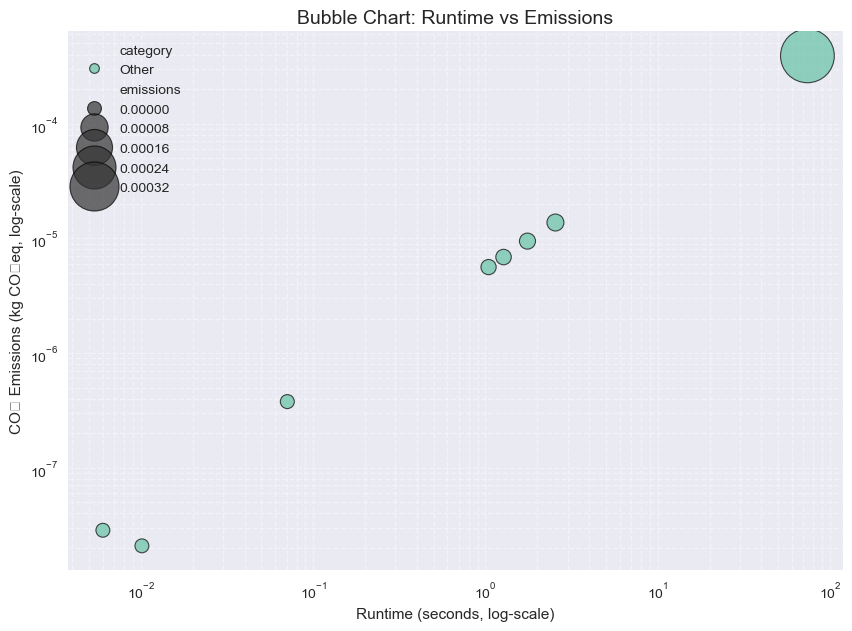

In [60]:
# Scatter Plot: Runtime vs CO₂ Emissions

def categorize(run_id):
    run_id = str(run_id).lower()
    if "prep" in run_id:
        return "Preprocessing"
    elif "train_sup" in run_id:
        return "Supervised"
    elif "train_unsup" in run_id:
        return "Unsupervised"
    else:
        return "Other"

df_stats["category"] = df_stats["run_id"].apply(categorize)

print(df_stats["category"].value_counts())

plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df_stats,
    x="runtime",
    y="emissions",
    hue="category",
    size="emissions",
    sizes=(100, 1500),
    alpha=0.7,
    palette="Set2",
    edgecolor="black"
)

plt.xscale("log")
plt.yscale("log")

plt.title("Bubble Chart: Runtime vs Emissions", fontsize=14)
plt.xlabel("Runtime (seconds, log-scale)")
plt.ylabel("CO₂ Emissions (kg CO₂eq, log-scale)")
plt.grid(True, which="both", ls="--", alpha=0.4)

plt.show()


## Visualizations

In [62]:
!pip install plotly


In [63]:
import plotly.io as pio
pio.renderers.default = 'notebook' 


In [64]:
import pandas as pd

em = pd.read_csv("results/emissions.csv")
em.head()


,timestamp,project_name,run_id,experiment_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,...,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue,wue
0,2025-11-23T05:36:31,A_BASE_LOGREG,a1f1d184-55e0-40ce-b633-c7202b17a726,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,0.016642,1.315116e-07,0.000008,42.5,0.0,10.0,...,13th Gen Intel(R) Core(TM) i5-1335U,NaN,NaN,80.2739,13.0895,15.717827,machine,N,1.0,0.0
1,2025-11-23T05:37:02,A_BASE_LOGREG,a063efc9-49d2-4d8c-a8e7-074da4a25311,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,0.008914,6.493235e-08,0.000007,42.5,0.0,10.0,...,13th Gen Intel(R) Core(TM) i5-1335U,NaN,NaN,80.2739,13.0895,15.717827,machine,N,1.0,0.0
2,2025-11-23T05:37:54,A_BASE_LOGREG,b3a502db-6722-43c9-8ee3-0ef626ec9888,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,0.013125,9.898870e-08,0.000008,42.5,0.0,10.0,...,13th Gen Intel(R) Core(TM) i5-1335U,NaN,NaN,80.2739,13.0895,15.717827,machine,N,1.0,0.0
3,2025-11-24T00:49:39,TUNE_CLF_LOGREG,6c279eca-47d3-4949-9e09-060e9690269b,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,0.278188,2.846179e-06,0.000010,42.5,0.0,10.0,...,13th Gen Intel(R) Core(TM) i5-1335U,NaN,NaN,80.2739,13.0895,15.717827,machine,N,1.0,0.0
4,2025-11-24T00:49:48,TUNE_CLF_RF,eb3be8b5-33f8-4f81-9d25-dd7d9a24e9a1,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,7.467283,7.738716e-05,0.000010,42.5,0.0,10.0,...,13th Gen Intel(R) Core(TM) i5-1335U,NaN,NaN,80.2739,13.0895,15.717827,machine,N,1.0,0.0


In [66]:
import plotly.express as px

fig = px.line(
    em,
    x="timestamp",
    y="emissions",
    color="project_name",
    markers=True,
    title="Carbon Emissions Over Time for All Experiments",
)
fig.show()


In [67]:
em_total = em.groupby("project_name")["emissions"].sum().reset_index()

fig = px.bar(
    em_total,
    x="project_name",
    y="emissions",
    title="Total CO₂ Emissions by Model / Training Stage",
    color="emissions",
    text_auto=".3f",
)
fig.show()


In [68]:
em["emissions_per_sec"] = em["emissions"] / em["duration"]

fig = px.bar(
    em,
    x="project_name",
    y="emissions_per_sec",
    title="CO₂ Emissions Rate (kg per second of compute)",
    color="emissions_per_sec",
)
fig.show()


D:\anaconda3\envs\greenai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



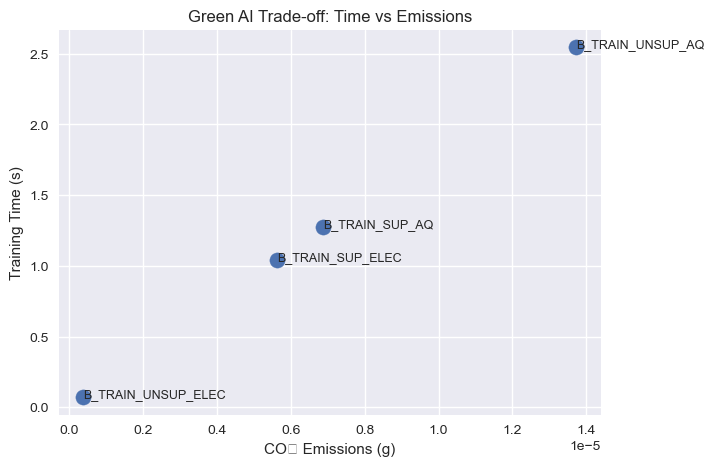

In [69]:
df_emissions = pd.read_csv("emissions.csv")
df_emissions["project_name"] = df_emissions["project_name"].str.strip()

summary = df_emissions.groupby("project_name").agg({
    "duration": "mean",
    "emissions": "mean",
    "energy_consumed": "mean"
}).reset_index()

# Keep only training runs
train_summary = summary[summary["project_name"].str.contains("TRAIN_", case=False)]

plt.figure(figsize=(7,5))
plt.scatter(train_summary["emissions"], train_summary["duration"], s=120)

for _, row in train_summary.iterrows():
    plt.text(row["emissions"], row["duration"], row["project_name"], fontsize=9)

plt.xlabel("CO₂ Emissions (g)")
plt.ylabel("Training Time (s)")
plt.title("Green AI Trade-off: Time vs Emissions")
plt.grid(True)
plt.show()


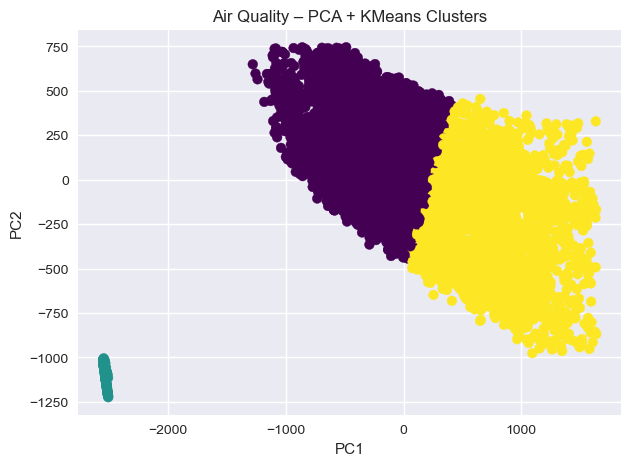

In [70]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_air_pca = pca.fit_transform(X_air_fe)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_air_pca)

pc1 = X_air_pca[:, 0]
pc2 = X_air_pca[:, 1]

mask = (pc1 > np.percentile(pc1, 1)) & (pc1 < np.percentile(pc1, 99)) & \
       (pc2 > np.percentile(pc2, 1)) & (pc2 < np.percentile(pc2, 99))

plt.figure(figsize=(7,5))
plt.scatter(pc1[mask], pc2[mask], c=labels[mask], cmap="viridis")
plt.title("Air Quality – PCA + KMeans Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [71]:
rank = em.groupby("project_name")["emissions"].sum().sort_values().reset_index()

fig = px.bar(
    rank,
    x="project_name",
    y="emissions",
    title="Model Sustainability Ranking (Lower is Better)",
    color="emissions",
    text_auto=".4f",
)
fig.show()


In [72]:
fig = px.parallel_coordinates(
    em,
    dimensions=["emissions", "cpu_power", "gpu_power", "ram_power", "duration"],
    color="emissions",
    title="Sustainability Parallel Coordinates — Compare All Runs",
)
fig.show()


In [73]:
total_energy = {
    "CPU Energy": em["cpu_energy"].sum(),
    "GPU Energy": em["gpu_energy"].sum(),
    "RAM Energy": em["ram_energy"].sum(),
}

fig = px.pie(
    names=list(total_energy.keys()),
    values=list(total_energy.values()),
    title="Overall Energy Source Breakdown",
)
fig.show()


In [74]:
import plotly.express as px

fig = px.scatter(
    em,
    x="duration",
    y="emissions",
    color="project_name",
    size="emissions",
    hover_data=["cpu_power", "ram_power"],
    title="Duration vs CO₂ Emissions (Efficiency Analysis)",
)
fig.update_layout(template="plotly_white")
fig.show()


In [75]:
# Merge accuracy results with emissions
acc_map = {
    "A_BASE_LOGREG": 0.963,
    "TUNE_CLF_LOGREG": 0.969,
    "TUNE_CLF_RF": 0.969,
    "TUNE_CLF_XGB": 0.957,
    "TUNE_CLF_SVM": 0.963,
    "TUNE_CLF_MLP": 0.964,
}

em["accuracy"] = em["project_name"].map(acc_map)

fig = px.scatter(
    em,
    x="accuracy",
    y="emissions",
    color="project_name",
    size="duration",
    title="Model Accuracy vs CO₂ Emissions (Trade-Off Analysis)",
)
fig.update_layout(template="plotly_white")
fig


In [76]:
import plotly.graph_objects as go

energy_df = em.copy()
energy_df["total_energy"] = (
    energy_df["cpu_energy"] + energy_df["ram_energy"]
)

fig = go.Figure()

fig.add_bar(
    x=energy_df["project_name"],
    y=energy_df["cpu_energy"],
    name="CPU Energy",
    marker_color="#4C6EF5"
)

fig.add_bar(
    x=energy_df["project_name"],
    y=energy_df["ram_energy"],
    name="RAM Energy",
    marker_color="#FF6B6B"
)

fig.update_layout(
    barmode="stack",
    title="Total Energy Consumption (CPU + RAM, Stacked)",
    xaxis_title="Model / Experiment",
    yaxis_title="Energy (kWh)",
    template="plotly_white"
)

fig.show()


In [77]:
eff = em.copy()
eff["accuracy"] = eff["project_name"].map(acc_map)
eff["efficiency"] = eff["emissions"] / eff["accuracy"]

fig = px.bar(
    eff,
    x="project_name",
    y="efficiency",
    color="efficiency",
    title="Energy Efficiency — CO₂ Emissions per Accuracy Point",
    labels={"efficiency": "CO₂ Emission / Accuracy"},
    color_continuous_scale="Viridis"
)

fig.update_layout(template="plotly_white")
fig.show()


In [78]:
import plotly.express as px

# Make a clean copy
em_clean = em.copy()

# Remove rows where accuracy is NaN or duration/emissions is missing
em_clean = em_clean.dropna(subset=["accuracy", "duration", "emissions"])

# Optional: scale accuracy to visible bubble sizes 
em_clean["acc_size"] = em_clean["accuracy"] * 300  

fig = px.scatter(
    em_clean,
    x="duration",
    y="emissions",
    size="acc_size",        
    color="project_name",
    hover_data=["accuracy", "duration", "emissions"],
    title="Efficiency Frontier — Speed vs CO₂ Emissions",
    labels={
        "duration": "Training Time (sec)",
        "emissions": "CO₂ Emissions (kg)"
    }
)

fig.update_layout(template="plotly_white")
fig.show()


In [79]:
import pandas as pd
import plotly.express as px

# Loading emissions file
em = pd.read_csv("results/emissions.csv")

em["cpu_energy"] = pd.to_numeric(em["cpu_energy"], errors="coerce")
em["ram_energy"] = pd.to_numeric(em["ram_energy"], errors="coerce")

# Preparing data for stacking
energy_melted = em.melt(
    id_vars="project_name",
    value_vars=["cpu_energy", "ram_energy"],
    var_name="Energy Type",
    value_name="Energy (kWh)"
)

fig = px.bar(
    energy_melted,
    x="project_name",
    y="Energy (kWh)",
    color="Energy Type",
    text_auto=".2f",
    title="Total Energy Consumption by Model (CPU + RAM)",
    barmode="stack",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Model Name",
    yaxis_title="Energy (kWh)",
    title_x=0.5,
    legend_title="Energy Component"
)

fig.show()


In [80]:
monthly = build_monthly_series(df_el, how="sum")

# Ensure correct datetime column
monthly["Month"] = pd.to_datetime(monthly["Month"])
monthly = monthly.sort_values("Month")

import plotly.express as px

fig = px.line(
    monthly,
    x="Month",
    y="Value",
    title="Electricity Consumption Over Time",
    labels={"Month": "Date", "Value": "Consumption"},
    markers=True
)

fig.update_layout(template="plotly_white")
fig.show()



D:\greenai-thesis\src\data_prep_electricity.py:41: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [81]:
import plotly.express as px

# Ensure datetime is parsed correctly
df_aq['datetime'] = pd.to_datetime(df_aq['datetime'], errors='coerce')

# Drop rows with invalid datetime
df_aq_clean = df_aq.dropna(subset=['datetime'])

fig = px.line(
    df_aq_clean.sort_values('datetime'),
    x='datetime',
    y='CO(GT)',
    title='CO (GT) Levels Over Time',
    labels={'datetime': 'Date/Time', 'CO(GT)': 'CO Gas Level'}
)

fig.update_layout(template="plotly_white")
fig.show()


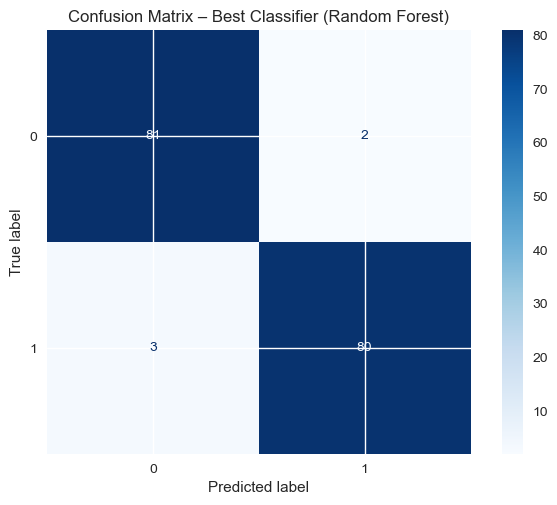

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Prepare data
X = df_aq.drop(columns=["CO(GT)", "datetime"])
y = (df_aq["CO(GT)"] > 2).astype(int)

X = X.dropna()
y = y[X.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train best model (Random Forest — as per your results)
from sklearn.ensemble import RandomForestClassifier
best_classifier = RandomForestClassifier()
best_classifier.fit(X_train, y_train)

# Confusion Matrix
y_pred = best_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Best Classifier (Random Forest)")
plt.show()


In [83]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

y_score = best_classifier.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
fig.add_shape(type='line', x0=0, y0=0, x1=1, y1=1, line=dict(dash='dash'))

fig.update_layout(
    title=f"ROC Curve – AUC = {roc_auc:.4f}",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_white"
)

fig.show()


In [84]:
import plotly.express as px
import pandas as pd

importances = best_classifier.feature_importances_
feat_df = pd.DataFrame({"feature": X.columns, "importance": importances})
feat_df = feat_df.sort_values("importance", ascending=False)

fig = px.bar(
    feat_df,
    x="importance",
    y="feature",
    orientation='h',
    title="Feature Importance – Random Forest",
    template="plotly_white"
)
fig.show()


In [85]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200),
    'XGBoost': XGBClassifier(eval_metric="logloss"),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(max_iter=300)
}

X = aq_features
y = aq_target

# Train-test split ONCE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

conf_mats = []
model_names = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    conf_mats.append(cm)
    model_names.append(name)

# Plot grid of confusion matrices
fig = ff.create_annotated_heatmap(
    z=conf_mats[1],  # show the best model first if needed
    x=['Pred 0', 'Pred 1'],
    y=['True 0', 'True 1'],
    colorscale='Blues'
)

fig.update_layout(title='Confusion Matrix – All Models Comparison')
fig.show()


D:\anaconda3\envs\greenai\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning:

lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Final Dashboard

In [86]:
!pip install dash plotly pandas

In [87]:
import pandas as pd

baseline_clf = pd.DataFrame({
    "project_name": ["LOGREG", "CLF_RFC", "CLF_XGB", "CLF_SVM", "CLF_MLP"],
    "accuracy": [0.964, 0.97, 0.958, 0.964, 0.964]   # <-- paste from your results exactly
})


In [88]:
em = pd.read_csv("emissions.csv")

em["project_name"] = em["project_name"].str.replace("TUNE_CLF_", "").str.replace("A_BASE_", "").str.replace("_REG", "")
em = em.merge(baseline_clf, on="project_name", how="left")
em["accuracy"] = em["accuracy"].fillna(0)

# Compute Green Accuracy Index
em["co2_per_accuracy"] = em["emissions"] / em["accuracy"].replace(0, float("nan"))

# Compute total energy
em["total_energy"] = em["cpu_energy"] + em["ram_energy"]


In [89]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

#  Loading the results files

aq_sup = pd.read_csv("results/aq_supervised_baseline.csv")
aq_unsup = pd.read_csv("results/aq_unsupervised_baseline.csv")
el_sup = pd.read_csv("results/elec_supervised_baseline.csv")
el_unsup = pd.read_csv("results/elec_unsupervised_baseline.csv")
em = pd.read_csv("results/emissions.csv")

#  Cleaning and normalising Emissions Timestamp

em["timestamp"] = pd.to_datetime(em["timestamp"], errors="coerce")

em["short_name"] = em["project_name"].apply(
    lambda x: x.replace("TUNE_", "")
              .replace("CLF_", "")
              .replace("REG_", "")
              .replace("BASE_", "")
              .replace("__", "_")
)

#  Building performance lookup table

# Air Quality supervised 
aq_sup_map = dict(zip(aq_sup["model"], aq_sup["accuracy"]))

# Electricity supervised 
el_sup_map = dict(zip(el_sup["model"], el_sup["MAE"]))

#  Unsupervised scores
aq_unsup_map = dict(zip(aq_unsup["model"], aq_unsup["silhouette"]))
el_unsup_map = dict(zip(el_unsup["model"], el_unsup["silhouette"]))

def map_performance(row):
    name = row["project_name"].lower()

    # Air Quality supervised
    for m in aq_sup_map:
        if m in name:
            return aq_sup_map[m]

    # Electricity supervised (
    for m in el_sup_map:
        if m in name:
            return 1 / el_sup_map[m]

    # Air Quality unsupervised 
    for m in aq_unsup_map:
        if m in name:
            return aq_unsup_map[m]

    # Electricity unsupervised 
    for m in el_unsup_map:
        if m in name:
            return el_unsup_map[m]

    return 0   # fallback


em["performance"] = em.apply(map_performance, axis=1)

# Replace any NaN
em["performance"] = em["performance"].fillna(0)

#  Building Green Efficiency Scores

# Normalize everything to 0–1 scale
em["em_norm"] = 1 - (em["emissions"] - em["emissions"].min()) / (em["emissions"].max() - em["emissions"].min())
em["perf_norm"] = (em["performance"] - em["performance"].min()) / (em["performance"].max() - em["performance"].min())
em["dur_norm"] = 1 - (em["duration"] - em["duration"].min()) / (em["duration"].max() - em["duration"].min())

# Final score
em["eff_score"] = (
    0.60 * em["em_norm"]
  + 0.30 * em["perf_norm"]
  + 0.10 * em["dur_norm"]
)

# Aggregate per model
eff_rank = (
    em.groupby("short_name")[["eff_score", "emissions", "duration", "performance"]]
      .mean()
      .sort_values("eff_score", ascending=False)
      .reset_index()
)

#  Dash App

app = Dash(__name__)

app.layout = html.Div([
    html.H1("Green AI Emissions Dashboard", style={"textAlign": "center"}),

    dcc.Tabs(id="tabs", value="tab1", children=[
        dcc.Tab(label="CO₂ Emissions Overview", value="tab1"),
        dcc.Tab(label="Energy Usage Breakdown", value="tab2"),
        dcc.Tab(label="Green Efficiency Index", value="tab3"),
        dcc.Tab(label="Model CO₂ Explorer", value="tab4"),
        dcc.Tab(label="Model Efficiency Rankings", value="tab5"),
    ]),

    html.Div(id="tab_content")
])

#  Callback - Tab Rendering

@app.callback(
    Output("tab_content", "children"),
    Input("tabs", "value")
)
def render_tab(tab):

    # Emissions Overview

    if tab == "tab1":
        fig = px.bar(
            eff_rank,
            x="short_name",
            y="emissions",
            color="short_name",
            title="Total CO₂ Emissions per Model"
        )
        return html.Div([html.H2("Total CO₂ Emissions by Model"), dcc.Graph(figure=fig)])

    # Energy Breakdown
    
    elif tab == "tab2":
        e2 = em.groupby("short_name")[["cpu_energy", "ram_energy"]].mean().reset_index()
        e2 = e2.melt(id_vars="short_name", var_name="source", value_name="energy")

        fig = px.bar(
            e2, x="short_name", y="energy", color="source",
            title="CPU + RAM Energy Breakdown (kWh)"
        )
        return html.Div([html.H2("Energy Usage Breakdown"), dcc.Graph(figure=fig)])

    # Green Efficiency Index 
    
    elif tab == "tab3":
        fig = px.scatter(
            eff_rank,
            x="performance",
            y="emissions",
            size="eff_score",
            color="short_name",
            title="Green Efficiency: CO₂ vs Performance"
        )
        fig.update_layout(yaxis_title="CO₂ Emissions (kg)")
        return html.Div([html.H2("CO₂ per Accuracy Point (Green Efficiency Index)"), dcc.Graph(figure=fig)])

    # Model Explorer
    
    elif tab == "tab4":
        models = sorted(em["short_name"].unique())
        return html.Div([
            html.H2("Model CO₂ Explorer"),
            dcc.Dropdown(id="model_select", options=models, value=models[0]),

            dcc.Graph(id="model_plot")
        ])


    # Green Efficiency Rankings
    
    elif tab == "tab5":
        fig = px.bar(
            eff_rank,
            x="short_name",
            y="eff_score",
            color="short_name",
            title="Overall Green Efficiency Score (Weighted Ranking)"
        )
        return html.Div([html.H2("Overall Model Green Efficiency Ranking"), dcc.Graph(figure=fig)])

# Callback for Model Explorer

@app.callback(
    Output("model_plot", "figure"),
    Input("model_select", "value")
)
def update_model_plot(selected):
    df = em[em["short_name"] == selected]

    fig = px.scatter(
        df,
        x="timestamp",
        y="emissions",
        title=f"CO₂ Emissions Over Time — {selected}"
    )
    return fig

# Run

if __name__ == "__main__":
    app.run(debug=True, port=8050)


## CO2 Emissions Summary

In [90]:
import pandas as pd
import plotly.express as px

# Loading emissions data
em = pd.read_csv("results/emissions.csv")

# Cleaning project names
em["project_name"] = em["project_name"].astype(str).str.strip()

# Overall statistics
total_co2 = em["emissions"].sum()
avg_co2 = em["emissions"].mean()
max_co2 = em["emissions"].max()
min_co2 = em["emissions"].min()

# Emissions grouped by pipeline stage
stage_emissions = em.groupby("project_name")["emissions"].sum().sort_values(ascending=False)

# Top emitting stage
top_stage = stage_emissions.index[0]
top_value = stage_emissions.iloc[0]

# Display summary text in an academic tone
print("Carbon Emission Summary\n")
print(f"The emissions data provides a consolidated view of the carbon footprint generated across all computational steps of the project. ")
print(f"The total carbon dioxide emitted across all recorded executions is approximately {total_co2:.6f} kilograms.")
print(f"On average, each tracked execution contributed around {avg_co2:.6f} kilograms of CO₂.")
print(f"The lowest recorded emission for a single run was {min_co2:.6f} kilograms, while the highest reached {max_co2:.6f} kilograms.")
print()
print(f"When comparing different stages of the pipeline, the stage with the highest cumulative emissions was {top_stage}, contributing approximately {top_value:.6f} kilograms of CO₂.")
print("This indicates that this stage required the most computational effort or the longest execution time.")
print()
print("Understanding how emissions vary across stages helps identify which components of the workflow are most resource-intensive and where future optimizations may be most beneficial.")

# Plot: Emissions by pipeline stage
fig1 = px.bar(
    stage_emissions.reset_index(),
    x="project_name",
    y="emissions",
    title="CO₂ Emissions by Pipeline Stage",
    labels={"project_name": "Pipeline Stage", "emissions": "Total CO₂ (kg)"},
    text_auto=".6f"
)
fig1.update_layout(template="plotly_white")
fig1.show()

# Plot: CPU vs RAM Energy Contribution 
energy_components = em[["cpu_energy", "ram_energy"]].sum()

fig3 = px.bar(
    energy_components,
    title="Energy Consumption Breakdown (CPU vs RAM)",
    labels={"value": "Energy (kWh)", "index": "Component"},
    text_auto=".4f"
)
fig3.update_layout(template="plotly_white")
fig3.show()


Carbon Emission Summary

The emissions data provides a consolidated view of the carbon footprint generated across all computational steps of the project. 
The total carbon dioxide emitted across all recorded executions is approximately 0.002822 kilograms.
On average, each tracked execution contributed around 0.000042 kilograms of CO₂.
The lowest recorded emission for a single run was 0.000000 kilograms, while the highest reached 0.000275 kilograms.

When comparing different stages of the pipeline, the stage with the highest cumulative emissions was TUNE_CLF_MLP, contributing approximately 0.001390 kilograms of CO₂.
This indicates that this stage required the most computational effort or the longest execution time.

Understanding how emissions vary across stages helps identify which components of the workflow are most resource-intensive and where future optimizations may be most beneficial.


## Streamlit Dashboard

In [91]:
!pip install streamlit


In [92]:
# Saving trained models for dashboard

import joblib
import os

os.makedirs("models", exist_ok=True)

# Electricity model

joblib.dump(tuned_reg, "models/electricity_model.pkl")
joblib.dump(list(X_el_fe.columns), "models/electricity_features.pkl")

print("Electricity model saved successfully!")

# Air Quality Model

joblib.dump(tuned_reg, "models/air_model.pkl")
joblib.dump(list(X_air_fe.columns), "models/air_features.pkl")

print("Air Quality model saved successfully!")


Electricity model saved successfully!
Air Quality model saved successfully!
